# Interpret Reactions with Howso Engine

## Overview

This notebook provides an overview of applying Howso Engine to make predictions based on trained data and harnessing Howso Engine’s interpretability capabilities to understand why the predictions were made. Here, we demonstrate these capabilities on asteroid data. We build a Howso Engine Trainee to predict various information about different asteroids, understand the influential cases on the predictions, and understand the uncertainty of the predictions. This is a straightforward example of the power of Howso Engine to gain insights from data. 

In [1]:
import pandas as pd

from howso.engine import Trainee
from howso.utilities import infer_feature_attributes
from howso.visuals import plot_interpretable_prediction

## Step 1: Load the Data

For this demonstration we will use a subset of a dataset containing measurements of various asteroids

In [2]:
dataset_path = "../../../data/asteroid.csv"
df_full = pd.read_csv(dataset_path, low_memory=False)
header = list(df_full)
df = df_full.truncate(after=5000)
df = df.where(df.notnull(), None)

df

,full_name,a,e,G,i,om,w,q,ad,per_y,...,rot_per,GM,BV,UB,IR,spec_B,spec_T,neo,pha,moid
0,1 Ceres,2.769165,0.076009,0.12,10.594067,80.305532,73.597694,2.558684,2.979647,4.608202,...,9.074170,62.6284,0.713,0.426,NaN,C,G,N,N,1.594780
1,2 Pallas,2.772466,0.230337,0.11,34.836234,173.080063,310.048857,2.133865,3.411067,4.616444,...,7.813200,14.3000,0.635,0.284,NaN,B,B,N,N,1.233240
2,3 Juno,2.669150,0.256942,0.32,12.988919,169.852760,248.138626,1.983332,3.354967,4.360814,...,7.210000,NaN,0.824,0.433,NaN,Sk,S,N,N,1.034540
3,4 Vesta,2.361418,0.088721,0.32,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,...,5.342128,17.8000,0.782,0.492,NaN,V,V,N,N,1.139480
4,5 Astraea,2.574249,0.191095,NaN,5.366988,141.576604,358.687608,2.082324,3.066174,4.130323,...,16.806000,NaN,0.826,0.411,NaN,S,S,N,N,1.095890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,4997 Ksana (1986 TM),2.871173,0.329960,NaN,32.732948,10.726564,57.718579,1.923802,3.818544,4.865161,...,3.434200,NaN,NaN,NaN,NaN,B,None,N,N,1.058150
4997,4998 Kabashima (1986 VG),3.007439,0.073460,NaN,9.904038,352.226415,100.901739,2.786511,3.228367,5.215590,...,6.138000,NaN,NaN,NaN,NaN,None,None,N,N,1.824890
4998,4999 MPC (1987 CJ),3.015442,0.040212,NaN,10.473593,155.933107,344.673442,2.894184,3.136701,5.236423,...,NaN,NaN,NaN,NaN,NaN,None,None,N,N,1.907750
4999,5000 IAU (1987 QN7),2.537905,0.263911,NaN,6.265176,150.922214,232.797213,1.868123,3.207687,4.043163,...,NaN,NaN,NaN,NaN,NaN,None,None,N,N,0.878287


## Step 2: Define and verify the feature attributes

We use `infer_feature_attributes` to define feature attributes for our dataset, then print out the feature attributes to ensure they are correct.

In [3]:
features = infer_feature_attributes(df)

features.to_dataframe()

type decimal_places     bounds                        \
                                          allow_null    min            max   
full_name          nominal            NaN       True    NaN            NaN   
a               continuous            9.0       True  0.000      21.996816   
e               continuous            9.0       True  0.000       1.465503   
G               continuous            2.0       True -0.590       1.070000   
i               continuous            9.0       True  0.000     105.495187   
om              continuous            9.0       True  0.000     593.499906   
w               continuous            9.0       True  0.000     593.401081   
q               continuous            9.0       True  0.000      13.871749   
ad              continuous            9.0       True  0.000      30.368813   
per_y           continuous            9.0       True  0.000      82.830928   
data_arc        continuous            0.0      False  0.000  115039.000000   
condition_code  continuous            0.0       True  0.000       3.000000   
n_obs_used      continuous            0.0      False  0.000   15341.000000   
H               continuous            2.0       True  0.000      32.050000   
diameter           nominal            NaN       True    NaN            NaN   
extent             nominal            NaN       True    NaN            NaN   
albedo          continuous            4.0       True  0.000       1.643500   
rot_per         continuous            5.0       True  0.000    2704.838010   
GM              continuous            6.0       True  0.000     103.256486   
BV              continuous            3.0       True  0.258       1.399000   
UB              continuous            3.0       True  0.000       1.002000   
IR              continuous            NaN       True    NaN            NaN   
spec_B             nominal            NaN       True    NaN            NaN   
spec_T             nominal            NaN       True    NaN            NaN   
neo                nominal            NaN       True    NaN            NaN   
pha                nominal            NaN       True    NaN            NaN   
moid            continuous            7.0       True  0.000      12.315600   

                                          data_type original_type       
               observed_min  observed_max               data_type size  
full_name               NaN           NaN       NaN        string  NaN  
a                  0.832030     13.669122    number       numeric  8.0  
e                  0.002606      0.889898    number       numeric  8.0  
G                 -0.120000      0.600000    number       numeric  8.0  
i                  0.052952     64.006900    number       numeric  8.0  
om                 0.000735    359.976179    number       numeric  8.0  
w                  0.012874    359.921015    number       numeric  8.0  
q                  0.139981      8.468719    number       numeric  8.0  
ad                 1.143439     18.869524    number       numeric  8.0  
per_y              0.758956     50.538124    number       numeric  8.0  
data_arc        7394.000000  72684.000000    number       integer  8.0  
condition_code     0.000000      2.000000    number       numeric  8.0  
n_obs_used        51.000000   9325.000000    number       integer  8.0  
H                  3.200000     20.700000    number       numeric  8.0  
diameter                NaN           NaN       NaN        string  NaN  
extent                  NaN           NaN       NaN        string  NaN  
albedo             0.008000      1.000000    number       numeric  8.0  
rot_per            1.100000   1641.000000    number       numeric  8.0  
GM                 0.000446     62.628400    number       numeric  8.0  
BV                 0.580000      1.077000    number       numeric  8.0  
UB                 0.120000      0.655000    number       numeric  8.0  
IR                      NaN           NaN    number       numeric  8.0  
spec_B 

## Step 3: Create and Train a Trainee

As is the usual Howso Engine workflow: We create a Trainee, then train and analyze.

In [4]:
action_feature = ['moid']
context_features = features.get_names(without=['moid'])

trainee = Trainee(name='Engine - Interpretable Predictions Recipe', features=features, overwrite_existing=True)

trainee.train(df)

trainee.analyze()

## Step 4: React

First, we'll select one case to react to for demonstration purposes. 

This case is selected from the cases which were **_not_** trained, so the model does not know about this case in particular.

In [5]:
predict_index = 200001

df_full = df_full.astype(object)
df_full = df_full.where(df_full.notnull(), None) # convert NaN to None
case = df_full[predict_index:predict_index+1].iloc[0]  # grab a case that wasn't trained
context_values = case.iloc[0:26].tolist()
action_value = case.iloc[26]

In [6]:
df_full[predict_index:predict_index+1]

,full_name,a,e,G,i,om,w,q,ad,per_y,...,rot_per,GM,BV,UB,IR,spec_B,spec_T,neo,pha,moid
200001,200002 Hehe (2007 JZ43),2.409757,0.158912,None,6.959368,116.592076,198.714295,2.026818,2.792696,3.740831,...,None,None,None,None,None,None,None,N,N,1.01338


### Next, we react.

When we call `react`, we include a request for certain `details`. Namely, `influential cases`. This will retrieve all of the cases which influenced the prediction and return them alongside the prediction itself. These can be used to interpret the prediction.

In [7]:
react = trainee.react(context_features=context_features,
                      action_features=action_feature,
                      contexts=[context_values],
                      details = {
                          'influential_cases': True,
                          'feature_full_residuals': True
                      })


print('Predicted action feature:')
display(react['action'])

local_residual = react['details']['feature_full_residuals'][0][action_feature[0]]
print('Local MAE of action feature:')
display(local_residual)

print('Computed explanation: ')
display(react['details'])

Predicted action feature:


,moid
0,1.016919


Local MAE of action feature:


0.04417584899043508

Computed explanation: 


{'action_features': ['moid'],
 'influential_cases': [[{'ad': 2.766952921,
    'H': 13.8,
    'pha': 'N',
    'full_name': '  4579 Puccini (1989 AT6)',
    '.influence_weight': 0.05054825389986568,
    'albedo': None,
    'rot_per': None,
    'G': None,
    'per_y': 3.716004457,
    'w': 139.8868548,
    'UB': None,
    'condition_code': 0,
    'spec_T': None,
    '.session': 'f4e21daf-83f1-4c3f-b504-96fcaf96938a',
    'diameter': None,
    'a': 2.39908342,
    'moid': 1.01725,
    '.session_training_index': 4578,
    'GM': None,
    'i': 2.213643473,
    'q': 2.031213919,
    'IR': None,
    'n_obs_used': 2229,
    'neo': 'N',
    'extent': None,
    'e': 0.15333752,
    'om': 111.4133909,
    'BV': None,
    'data_arc': 15040,
    'spec_B': None},
   {'ad': 2.637729516,
    'H': 13.7,
    'pha': 'N',
    'full_name': '  4444 Escher (1985 SA)',
    '.influence_weight': 0.0502294537245404,
    'albedo': None,
    'rot_per': None,
    'G': None,
    'per_y': 3.541706878,
    'w': 181.908

## Step 5: View the influential cases

The predicted case and the influential cases can be viewed side-by-side.

In [8]:
pd.options.display.max_columns = None #show all features

most_similar_df = pd.DataFrame(react['details']['influential_cases'][0])
most_similar_df = most_similar_df.drop(['.session_training_index', '.session'], axis=1)

display(df_full.iloc[predict_index:predict_index+1])
display(most_similar_df[header])

,full_name,a,e,G,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,H,diameter,extent,albedo,rot_per,GM,BV,UB,IR,spec_B,spec_T,neo,pha,moid
200001,200002 Hehe (2007 JZ43),2.409757,0.158912,None,6.959368,116.592076,198.714295,2.026818,2.792696,3.740831,6472,0.0,226,16.7,None,None,None,None,None,None,None,None,None,None,N,N,1.01338


,full_name,a,e,G,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,H,diameter,extent,albedo,rot_per,GM,BV,UB,IR,spec_B,spec_T,neo,pha,moid
0,4579 Puccini (1989 AT6),2.399083,0.153338,None,2.213643,111.413391,139.886855,2.031214,2.766953,3.716004,15040,0,2229,13.8,None,None,NaN,None,None,None,None,None,None,None,N,N,1.017250
1,4444 Escher (1985 SA),2.323466,0.135256,None,7.391794,121.256649,181.908910,2.009202,2.637730,3.541707,12336,0,2124,13.7,None,None,NaN,None,None,None,None,None,None,None,N,N,0.993099
2,3857 Cellino (1984 CD1),2.393302,0.159857,None,3.088999,48.936628,178.271217,2.010716,2.775889,3.702580,22479,0,2030,13.4,5.839,None,0.226,None,None,None,None,None,None,None,N,N,1.001030
3,1937 Locarno (1973 YA),2.377241,0.156319,None,12.457940,78.961626,226.373937,2.005633,2.748848,3.665371,30232,0,2146,11.7,12.705,None,0.229,None,None,None,None,None,None,None,N,N,1.009820
4,4661 Yebes (1982 WM),2.435531,0.160288,None,4.704551,102.503409,286.133193,2.045144,2.825918,3.801008,20422,0,2019,13.4,5.996,None,0.217,None,None,None,None,None,None,None,N,N,1.055520
5,2614 Torrence (1980 LP),2.338217,0.168234,None,6.914271,105.538088,228.162813,1.944850,2.731585,3.575490,15723,0,2209,13.0,None,None,NaN,None,None,None,None,None,None,None,N,N,0.941097
6,3929 Carmelmaria (1981 WG9),2.380485,0.136654,None,2.890069,153.144619,221.996506,2.055182,2.705788,3.672877,24221,0,1751,13.7,5.953,None,0.163,None,None,None,None,None,None,None,N,N,1.056220
7,4864 Nimoy (1988 RA5),2.469210,0.176672,None,3.619257,94.126605,241.625734,2.032970,2.905451,3.880121,22642,0,1783,13.4,11.874,None,0.054,None,None,None,None,None,None,None,N,N,1.025300
8,4312 Knacke (1978 WW11),2.384353,0.151864,None,4.429878,91.178857,287.303230,2.022256,2.746451,3.681833,32237,0,2033,13.3,12.384,None,0.061,None,None,None,None,None,None,None,N,N,1.028970
9,4556 Gumilyov (1987 QW10),2.310577,0.144530,None,4.752458,111.851272,213.619211,1.976628,2.644526,3.512278,14227,0,2031,13.6,5.224,None,0.282,None,None,None,None,None,None,None,N,N,0.965607


## Step 6: Intepret

We react several more times generatively to determine a range of possible predicted values.

These will be used to visualize the distribution of the predicted feature compared to the held-out case, the predicted case, and the influential cases. This visualization is one of many techniques which could be used to interpret the results.

In [9]:
gen_reacts = list()
for i in range(0,200):
    result =  trainee.react(context_features=context_features,
                            action_features=action_feature,
                            contexts=[context_values],
                            desired_conviction = 5000)
    gen_reacts.append(result['action'].loc[0, 'moid'])

/home/runner/.local/lib/python3.10/site-packages/plotly/io/_base_renderers.py:123: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




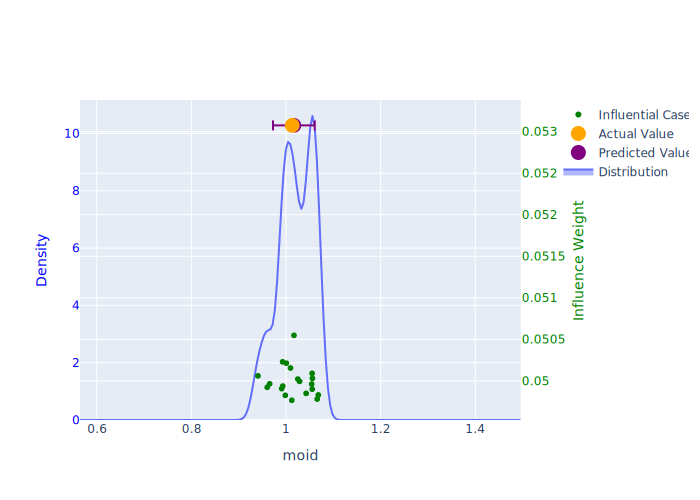

In [10]:
plot_interpretable_prediction(
    react,
    actual_value=action_value,
    generative_reacts=gen_reacts,
    residual=local_residual,
)

This visualization show us the probability density of the action feature value given the context as well as the values of the influential cases and their corresponding influence weights. All of this information is at the core of how the Howso Engine makes its predictions, which should elucidate the information that is used when the Trainee makes a prediction.

## Step 7: Use a non-visual interpretation

Howso Engine provides a number of tools for interpreting reacts. Below, we compare the MDA (Mean Decrease in Accuracy) for the predicted case and the original case. Inspecting the difference between these MDA values can indicate to the user how much the local model changes when the action feature and value become part of the context that determines the influential cases.

> Reminder: The "local model" is the region of the data surrounding a prediction made up by its influential cases. In contrast, the entire dataset can be referred to as the "global model".

In [11]:
react = trainee.react(context_features=context_features,
                      action_features=action_feature,
                      contexts=[context_values],
                      details = {
                         'feature_robust_accuracy_contributions': True,
                      })

loc_mda = react['details']['feature_robust_accuracy_contributions']

mda_dict = dict(sorted(loc_mda[0].items(), key=lambda item: item[1], reverse=True))
mda_df = pd.DataFrame(columns=['original', 'predicted'])
mda_df['predicted'] = mda_dict.values()
mda_df.index = mda_dict.keys()

react2 = trainee.react(context_features=context_features,
                       action_features=action_feature,
                       actions=[[action_value]],  # specify "actual" actual value
                       contexts=[context_values],
                       details = {
                           'feature_robust_accuracy_contributions_ex_post': True,
                       })

loc_mda_post_facto = react2['details']['feature_robust_accuracy_contributions_ex_post']
mda_dict = dict(sorted(loc_mda_post_facto[0].items(), key=lambda item: item[1], reverse=True))
mda_df['original'] = mda_dict.values()

display(mda_df)

,original,predicted
q,0.048078,0.030570
e,0.043278,0.021157
GM,0.033600,0.019787
a,0.029251,0.014498
extent,0.025624,0.013921
per_y,0.025619,0.012038
pha,0.021492,0.010083
H,0.021242,0.008737
BV,0.020524,0.008356
IR,0.015030,0.004216


## Step 8. Investigating boundaries

Howso Engine also allows users to investigate what changes in the context of a prediction may change the predicted value. For example, a user might be interested in what context values for features "e" and "q" would cause the prediction for "moid" to fall below 0.95. The Engine supports this kind of investigation through the use of 2 details, "boundary_value_context_features" and "boundary_value_action_outcome". The former takes a list of context feature names whose values will be manipulated to search for a the boundary values where a prediction is most different or satisfies a condition. "boundary_value_action_outcome" takes a map of conditions for action features. Continuous features take a tuple defining the range and nominal values can either take a single value they must match or a list of possible values.

So with the code below, the user can find the values of 'e' or 'q' that would result in the prediction of "moid" falling between 0.0 and 0.95 (using the same context values for the rest of the context features). The resulting react returns these values under the "boundary_values" key of the details dictionary. Tuples are returned for continuous features such as "e" and "q" allowing for boundary values to be found both above and below the given context value for the react call. 

In [12]:
react = trainee.react(
    context_features=context_features,
    action_features=action_feature,
    contexts=[context_values],
    details = {
        'boundary_value_context_features': ['e', 'q'],
        'boundary_value_action_outcome': {"moid": [0.0, 0.95]}
    }
)
boundary_values = react['details']['boundary_values'][0]
boundary_values

{'q': [1.903689073, None], 'e': [None, 0.229292124]}

# Conclusion

This recipe further demonstrates the interpretability tools available to users alongside their predictions with the `react` call. When using a series of generative `react`'s alongside the discriminative `react` used for the prediction, users can visualize the probability distribution of the action feature given the specific context. Additionally, users can see the exact cases from the training data that were used to make the prediction.

This interpretability is crucial for many machine learning use-cases whether it be safety-critical applicaitons or any other model that can directly impact the lives of those affected by its decisions. Without interpretability, users must blindly accept model predictions which can often lead to incorrect predictions severely impacting people in often disproportional ways. The ability to maintain accuracy while providing full interpretability is at the core of the Howso Engine's design.